# Short Strategy Simulation (v2)

Backtest an improved daily shorting strategy using model predictions.

**Strategy Improvements:**
- Smaller K (5-10 positions) - signal is concentrated
- Multi-day holding period - reduce turnover
- Volatility-adjusted position sizing - less $ in volatile names
- Realistic transaction fees

**Fee Structure:**
- $0.005 per share
- Max 1% of trade value

**Contents:**
1. Load data and model scores
2. Define shortable universe
3. Improved backtest simulation
4. Compare strategies
5. Analyze results
6. Visualizations

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load Data and Model Scores

In [18]:
# Load dataset
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])

# Time-based split - use test set (last 15% of dates)
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
val_end_idx = int(n_dates * 0.85)
test_dates = set(dates[val_end_idx:])

test_df = df[df["feature_date"].isin(test_dates)].copy()

print(f"Test set: {len(test_df):,} rows")
print(f"Date range: {test_df['feature_date'].min().date()} to {test_df['feature_date'].max().date()}")
print(f"Trading days: {test_df['feature_date'].nunique()}")

Test set: 352,213 rows
Date range: 2025-02-11 to 2025-12-18
Trading days: 178


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from dataclasses import dataclass

@dataclass(frozen=True)
class ModelConfig:
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    fundamental_dropout: float = 0.2
    price_dropout: float = 0.2
    news_dropout: float = 0.3
    news_alpha: float = 0.7
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 1e-3
    n_epochs: int = 20
    pairs_per_day: int = 5000

class MultiBranchRanker(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, 64),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(64, config.fundamental_latent),
            nn.ReLU(),
        )
        
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, 32),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(32, config.price_latent),
            nn.ReLU(),
        )
        
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(128, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)

In [20]:
# Feature columns
price_feat_cols = [
    "overnight_gap_z", "intraday_ret_z",
    "ret_1d_z", "ret_2d_z", "ret_3d_z", "ret_5d_z",
    "vol_5d_z", "dist_from_high_5d_z", "dist_from_low_5d_z"
]
fund_feat_cols = [c for c in test_df.columns if c.endswith("_z") 
                  and c not in price_feat_cols and c != "news_count_z"]
emb_cols = [c for c in test_df.columns if c.startswith("emb_")]

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ModelConfig(
    n_fundamental_features=len(fund_feat_cols),
    n_price_features=len(price_feat_cols),
    n_embedding_dim=len(emb_cols),
)
model = MultiBranchRanker(config).to(device)
model.load_state_dict(torch.load("data/model_best.pt", weights_only=True))
model.eval()

print(f"Loaded model with {sum(p.numel() for p in model.parameters()):,} parameters")

Loaded model with 109,393 parameters


In [21]:
class PointwiseDataset(Dataset):
    def __init__(self, df, price_cols, fund_cols, emb_cols):
        self.price_arr = df[price_cols].values.astype(np.float32)
        self.fund_arr = df[fund_cols].values.astype(np.float32)
        self.emb_arr = df[emb_cols].values.astype(np.float32)
    
    def __len__(self):
        return len(self.price_arr)
    
    def __getitem__(self, idx):
        return {
            "price": torch.tensor(self.price_arr[idx]),
            "fund": torch.tensor(self.fund_arr[idx]),
            "emb": torch.tensor(self.emb_arr[idx]),
        }

@torch.no_grad()
def get_scores(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    model.eval()
    dataset = PointwiseDataset(df, price_cols, fund_cols, emb_cols)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    scores = []
    for batch in tqdm(loader, desc="Scoring", leave=False):
        price = batch["price"].to(device)
        fund = batch["fund"].to(device)
        emb = batch["emb"].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    return np.concatenate(scores)

# Score test data
test_df["score"] = get_scores(model, test_df, price_feat_cols, fund_feat_cols, emb_cols, device)
print(f"Scored {len(test_df):,} rows")

Scoring:   0%|          | 0/344 [00:00<?, ?it/s]

Scored 352,213 rows


## 2. Define Shortable Universe

In [22]:
# Load market cap data
key_metrics = pd.read_parquet("data/key_metrics.pqt")
key_metrics["date"] = pd.to_datetime(key_metrics["date"])

# Get latest market cap per symbol
latest_mcap = (
    key_metrics[["symbol", "date", "marketCap"]]
    .sort_values("date")
    .groupby("symbol")
    .last()
    .reset_index()
)

# Define shortable threshold
MIN_MCAP = 500_000_000  # $500M

shortable_symbols = set(latest_mcap[latest_mcap["marketCap"] >= MIN_MCAP]["symbol"])
print(f"Shortable symbols (mcap >= ${MIN_MCAP/1e6:.0f}M): {len(shortable_symbols):,}")

# Merge market cap into test_df
test_df = test_df.merge(latest_mcap[["symbol", "marketCap"]], on="symbol", how="left")

# Filter to shortable universe
test_shortable = test_df[test_df["symbol"].isin(shortable_symbols)].copy()
print(f"Test rows in shortable universe: {len(test_shortable):,} ({len(test_shortable)/len(test_df)*100:.1f}%)")

Shortable symbols (mcap >= $500M): 2,861
Test rows in shortable universe: 334,455 (95.0%)


In [23]:
# Compute rolling volatility for position sizing
# Use vol_5d_z as proxy (already computed in features)
# Higher vol = smaller position

# Get raw volatility from price features notebook if available
# For now, use the z-scored vol and invert transform approximately
test_shortable["volatility"] = test_shortable["vol_5d_z"].clip(-3, 3)  # Clip outliers

print(f"Volatility stats:")
print(test_shortable["volatility"].describe())

Volatility stats:
count    334455.000000
mean         -0.143918
std           0.331443
min          -0.901202
25%          -0.335230
50%          -0.191297
75%          -0.047222
max           3.000000
Name: volatility, dtype: float64


## 3. Improved Backtest Simulation

In [24]:
# Fee structure
FEE_PER_SHARE = 0.005  # $0.005 per share
MAX_FEE_PCT = 0.01     # Max 1% of trade value
INITIAL_CAPITAL = 50_000  # $50K starting capital (as requested)

def calculate_fees(trade_value: float, price: float) -> float:
    """
    Calculate trading fees.
    - $0.005 per share
    - Capped at 1% of trade value
    """
    n_shares = trade_value / price if price > 0 else 0
    per_share_fee = n_shares * FEE_PER_SHARE
    max_fee = trade_value * MAX_FEE_PCT
    return min(per_share_fee, max_fee)

# Test fee calculation
test_cases = [
    (10000, 50),   # $10K position, $50 stock -> 200 shares -> $1 fee
    (10000, 10),   # $10K position, $10 stock -> 1000 shares -> $5 fee
    (10000, 2),    # $10K position, $2 stock -> 5000 shares -> $25 fee, capped at $100 (1%)
]
print("Fee calculation examples:")
for val, price in test_cases:
    fee = calculate_fees(val, price)
    shares = val / price
    print(f"  ${val:,} @ ${price}/share = {shares:.0f} shares -> ${fee:.2f} fee")

Fee calculation examples:
  $10,000 @ $50/share = 200 shares -> $1.00 fee
  $10,000 @ $10/share = 1000 shares -> $5.00 fee
  $10,000 @ $2/share = 5000 shares -> $25.00 fee


In [25]:
def run_improved_backtest(
    df: pd.DataFrame,
    bottom_k: int = 10,
    hold_days: int = 1,
    vol_adjust: bool = True,
    initial_capital: float = INITIAL_CAPITAL,
    clip_return: float = 0.50,
    include_fees: bool = True,
    avg_price: float = 50.0,  # Assumed avg stock price for fee calc
) -> pd.DataFrame:
    """
    Improved short strategy with:
    - Multi-day holding period
    - Volatility-adjusted position sizing
    - Trading fees
    
    Parameters:
    -----------
    bottom_k : int
        Number of stocks to short
    hold_days : int
        Minimum days to hold position before reconsidering
    vol_adjust : bool
        If True, size positions inversely to volatility
    include_fees : bool
        Include trading fees in P&L
    """
    results = []
    capital = initial_capital
    
    # Track current positions and their entry dates
    current_positions = {}  # symbol -> {"entry_date": date, "size": dollars}
    
    dates = sorted(df["feature_date"].unique())
    
    for i, date in enumerate(dates):
        group = df[df["feature_date"] == date]
        if len(group) < bottom_k * 2:
            continue
        
        # Get bottom-K candidates
        candidates = group.nsmallest(bottom_k * 2, "score")  # Get more for filtering
        
        # Determine which positions to close (held >= hold_days and not in bottom-K)
        bottom_k_symbols = set(candidates.nsmallest(bottom_k, "score")["symbol"])
        
        positions_to_close = []
        for sym, pos in list(current_positions.items()):
            days_held = (date - pos["entry_date"]).days
            if days_held >= hold_days and sym not in bottom_k_symbols:
                positions_to_close.append(sym)
        
        # Close positions
        daily_pnl = 0
        daily_fees = 0
        
        for sym in positions_to_close:
            pos = current_positions.pop(sym)
            # Get today's return for this symbol
            sym_data = group[group["symbol"] == sym]
            if len(sym_data) > 0:
                ret = sym_data["target_return"].iloc[0]
                ret = np.clip(ret, -clip_return, clip_return)
                pnl = -pos["size"] * ret  # Short P&L
                daily_pnl += pnl
                
                # Exit fee
                if include_fees:
                    fee = calculate_fees(pos["size"], avg_price)
                    daily_fees += fee
        
        # Open new positions to fill up to bottom_k
        n_to_open = bottom_k - len(current_positions)
        if n_to_open > 0:
            # Get volatility for position sizing
            if vol_adjust and "vol_5d_z" in group.columns:
                candidates_to_open = candidates[~candidates["symbol"].isin(current_positions.keys())]
                candidates_to_open = candidates_to_open.nsmallest(n_to_open, "score").copy()
                
                # Inverse volatility weighting (lower vol = higher weight)
                # Use raw vol or fallback to equal weight
                vols = candidates_to_open["vol_5d_z"].fillna(0).values
                vols = np.clip(vols, 0.1, 3.0)  # Clip extreme z-scores
                inv_vols = 1.0 / (0.5 + vols)  # Add 0.5 to dampen effect
                weights = inv_vols / inv_vols.sum()
            else:
                candidates_to_open = candidates[~candidates["symbol"].isin(current_positions.keys())]
                candidates_to_open = candidates_to_open.nsmallest(n_to_open, "score")
                weights = np.ones(len(candidates_to_open)) / len(candidates_to_open)
            
            # Allocate capital
            available_capital = capital - sum(p["size"] for p in current_positions.values())
            
            for (_, row), weight in zip(candidates_to_open.iterrows(), weights):
                position_size = available_capital * weight
                current_positions[row["symbol"]] = {
                    "entry_date": date,
                    "size": position_size,
                }
                
                # Entry fee
                if include_fees:
                    fee = calculate_fees(position_size, avg_price)
                    daily_fees += fee
        
        # Calculate P&L for held positions
        for sym, pos in current_positions.items():
            sym_data = group[group["symbol"] == sym]
            if len(sym_data) > 0:
                ret = sym_data["target_return"].iloc[0]
                ret = np.clip(ret, -clip_return, clip_return)
                pnl = -pos["size"] * ret
                daily_pnl += pnl
        
        # Deduct fees
        daily_pnl -= daily_fees
        daily_return = daily_pnl / capital if capital > 0 else 0
        capital += daily_pnl
        
        results.append({
            "date": date,
            "pnl": daily_pnl,
            "return": daily_return,
            "capital": capital,
            "fees": daily_fees,
            "n_positions": len(current_positions),
            "symbols": list(current_positions.keys()),
            "turnover": len(positions_to_close) + n_to_open,
        })
    
    return pd.DataFrame(results)


# Also keep simple version for comparison
def run_simple_backtest(
    df: pd.DataFrame,
    bottom_k: int = 10,
    initial_capital: float = INITIAL_CAPITAL,
    clip_return: float = 0.50,
    include_fees: bool = True,
    avg_price: float = 50.0,
) -> pd.DataFrame:
    """Simple daily rebalance strategy (baseline)."""
    results = []
    capital = initial_capital
    
    for date, group in df.groupby("feature_date"):
        if len(group) < bottom_k * 2:
            continue
        
        shorts = group.nsmallest(bottom_k, "score").copy()
        position_size = capital / bottom_k
        
        # Fees: entry + exit for all positions (full turnover)
        if include_fees:
            total_fees = 2 * sum(calculate_fees(position_size, avg_price) for _ in range(bottom_k))
        else:
            total_fees = 0
        
        shorts["return_clipped"] = shorts["target_return"].clip(-clip_return, clip_return)
        shorts["pnl"] = -position_size * shorts["return_clipped"]
        
        daily_pnl = shorts["pnl"].sum() - total_fees
        daily_return = daily_pnl / capital
        capital += daily_pnl
        
        results.append({
            "date": date,
            "pnl": daily_pnl,
            "return": daily_return,
            "capital": capital,
            "fees": total_fees,
            "n_positions": len(shorts),
            "symbols": list(shorts["symbol"]),
            "turnover": bottom_k * 2,  # Full turnover
        })
    
    return pd.DataFrame(results)

print("Backtest functions defined:")
print("  - run_simple_backtest(): Daily rebalance baseline")
print("  - run_improved_backtest(): Multi-day hold + vol-adjusted sizing")

Backtest functions defined:
  - run_simple_backtest(): Daily rebalance baseline
  - run_improved_backtest(): Multi-day hold + vol-adjusted sizing


## 4. Compare Strategies

In [26]:
def compute_metrics(results: pd.DataFrame) -> dict:
    """Compute performance metrics from backtest results."""
    returns = results["return"]
    n_days = len(results)
    
    total_return = (results["capital"].iloc[-1] / INITIAL_CAPITAL - 1) * 100
    ann_return = ((1 + total_return/100) ** (252/n_days) - 1) * 100 if n_days > 0 else 0
    
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    sortino_denom = returns[returns < 0].std()
    sortino = returns.mean() / sortino_denom * np.sqrt(252) if sortino_denom > 0 else 0
    
    cumulative = (1 + returns).cumprod()
    max_dd = ((cumulative / cumulative.expanding().max()) - 1).min() * 100
    
    total_fees = results["fees"].sum()
    avg_turnover = results["turnover"].mean()
    
    return {
        "total_return": total_return,
        "ann_return": ann_return,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_dd": max_dd,
        "win_rate": (returns > 0).mean() * 100,
        "total_fees": total_fees,
        "avg_turnover": avg_turnover,
        "final_capital": results["capital"].iloc[-1],
    }

# Run multiple strategy variants
strategies = {}
all_backtests = {}  # For plotting

# 1. Simple daily rebalance (baseline)
for k in [5, 10, 20]:
    name = f"Simple K={k}"
    results = run_simple_backtest(test_shortable, bottom_k=k, include_fees=True)
    strategies[name] = {"results": results, "metrics": compute_metrics(results)}
    all_backtests[name] = results

# 2. Improved: multi-day hold
for k in [5, 10]:
    for hold in [3, 5]:
        name = f"Hold {hold}d K={k}"
        results = run_improved_backtest(
            test_shortable, bottom_k=k, hold_days=hold, 
            vol_adjust=False, include_fees=True
        )
        strategies[name] = {"results": results, "metrics": compute_metrics(results)}
        all_backtests[name] = results

# 3. Improved: vol-adjusted + multi-day hold
for k in [5, 10]:
    for hold in [3, 5]:
        name = f"Vol+Hold {hold}d K={k}"
        results = run_improved_backtest(
            test_shortable, bottom_k=k, hold_days=hold,
            vol_adjust=True, include_fees=True
        )
        strategies[name] = {"results": results, "metrics": compute_metrics(results)}
        all_backtests[name] = results

print(f"Tested {len(strategies)} strategy variants")

Tested 11 strategy variants


In [27]:
# Summary table
comparison_df = pd.DataFrame({
    name: strat["metrics"] for name, strat in strategies.items()
}).T

# Format for display
comparison_df = comparison_df.round(2)
comparison_df["final_capital"] = comparison_df["final_capital"].apply(lambda x: f"${x:,.0f}")
comparison_df["total_fees"] = comparison_df["total_fees"].apply(lambda x: f"${x:,.0f}")

# Sort by Sharpe ratio
comparison_df = comparison_df.sort_values("sharpe", ascending=False)

print("=" * 80)
print("STRATEGY COMPARISON (with fees)")
print("=" * 80)
print(f"\nInitial Capital: ${INITIAL_CAPITAL:,}")
print(f"Fee Structure: ${FEE_PER_SHARE}/share, max {MAX_FEE_PCT*100:.0f}% of trade value")
print(f"\n{comparison_df.to_string()}")

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
best_strat = comparison_df.index[0]
print(f"  Best Sharpe: {best_strat} (Sharpe={comparison_df.loc[best_strat, 'sharpe']:.2f})")
print(f"  Lowest Fees: {comparison_df['total_fees'].iloc[-1]} ({comparison_df.index[-1]})")
print(f"  Highest Return: {comparison_df['total_return'].max():.1f}% ({comparison_df['total_return'].idxmax()})")

STRATEGY COMPARISON (with fees)

Initial Capital: $50,000
Fee Structure: $0.005/share, max 1% of trade value

                  total_return  ann_return  sharpe  sortino  max_dd  win_rate total_fees  avg_turnover final_capital
Simple K=10              86.59      141.82    2.12     3.50  -36.74     52.25     $2,310         20.00       $93,294
Simple K=5              119.89      205.11    2.11     3.36  -43.01     55.06     $2,438         10.00      $109,943
Hold 3d K=5             142.83      251.15    2.06     3.68  -42.78     53.93       $760          3.28      $121,417
Hold 3d K=10            112.57      190.83    2.04     3.71  -41.16     56.74       $781          6.76      $106,283
Hold 5d K=10             82.97      135.21    1.77     3.10  -42.45     52.81       $458          4.27       $91,484
Vol+Hold 3d K=5         103.05      172.58    1.72     2.96  -44.75     55.62       $658          3.28      $101,527
Hold 5d K=5             109.63      185.16    1.71     2.49  -51.29    

## 5. Analyze Best Strategy

In [28]:
# Select best strategy (highest Sharpe with fees)
best_name = comparison_df.index[0]
best_results = strategies[best_name]["results"]
best_metrics = strategies[best_name]["metrics"]

print(f"Best Strategy: {best_name}")
print("-" * 40)

Best Strategy: Simple K=10
----------------------------------------


In [29]:
# Detailed analysis of best strategy
print("=" * 60)
print(f"DETAILED ANALYSIS: {best_name}")
print("=" * 60)

daily_returns = best_results["return"]
n_days = len(best_results)

print(f"\nPeriod: {best_results['date'].min().date()} to {best_results['date'].max().date()}")
print(f"Trading days: {n_days}")
print(f"Initial capital: ${INITIAL_CAPITAL:,}")
print(f"Final capital: ${best_results['capital'].iloc[-1]:,.0f}")

print(f"\n--- Returns ---")
print(f"Total return: {best_metrics['total_return']:.1f}%")
print(f"Annualized return: {best_metrics['ann_return']:.1f}%")
print(f"Daily mean return: {daily_returns.mean()*100:.3f}%")
print(f"Daily std: {daily_returns.std()*100:.3f}%")

print(f"\n--- Risk Metrics ---")
print(f"Sharpe ratio: {best_metrics['sharpe']:.2f}")
print(f"Sortino ratio: {best_metrics['sortino']:.2f}")
print(f"Max drawdown: {best_metrics['max_dd']:.1f}%")

print(f"\n--- Win/Loss ---")
print(f"Win rate: {best_metrics['win_rate']:.1f}%")
avg_win = daily_returns[daily_returns > 0].mean() * 100
avg_loss = daily_returns[daily_returns < 0].mean() * 100
print(f"Avg winning day: +{avg_win:.3f}%")
print(f"Avg losing day: {avg_loss:.3f}%")
if avg_loss != 0:
    print(f"Win/Loss ratio: {abs(avg_win/avg_loss):.2f}")

print(f"\n--- Costs ---")
print(f"Total fees paid: ${best_results['fees'].sum():,.0f}")
print(f"Fees as % of final capital: {best_results['fees'].sum() / best_results['capital'].iloc[-1] * 100:.2f}%")
print(f"Avg daily turnover: {best_results['turnover'].mean():.1f} positions")

# Compute gross P&L for fee impact analysis later
best_results["gross_pnl"] = best_results["pnl"] + best_results["fees"]

DETAILED ANALYSIS: Simple K=10

Period: 2025-02-11 to 2025-12-18
Trading days: 178
Initial capital: $50,000
Final capital: $93,294

--- Returns ---
Total return: 86.6%
Annualized return: 141.8%
Daily mean return: 0.394%
Daily std: 2.945%

--- Risk Metrics ---
Sharpe ratio: 2.12
Sortino ratio: 3.50
Max drawdown: -36.7%

--- Win/Loss ---
Win rate: 52.2%
Avg winning day: +2.605%
Avg losing day: -2.025%
Win/Loss ratio: 1.29

--- Costs ---
Total fees paid: $2,310
Fees as % of final capital: 2.48%
Avg daily turnover: 20.0 positions


In [30]:
# Most frequently shorted stocks in best strategy
all_symbols = [sym for symbols in best_results["symbols"] for sym in symbols]
symbol_counts = pd.Series(all_symbols).value_counts()

print(f"\n--- Top 15 Most Frequently Shorted ---")
for sym, count in symbol_counts.head(15).items():
    mcap = latest_mcap[latest_mcap["symbol"] == sym]["marketCap"].values
    mcap_str = f"${mcap[0]/1e9:.1f}B" if len(mcap) > 0 else "N/A"
    pct = count / len(best_results) * 100
    print(f"  {sym}: {count} days ({pct:.0f}%), mcap={mcap_str}")


--- Top 15 Most Frequently Shorted ---
  QUBT: 56 days (31%), mcap=$3.0B
  NRIX: 48 days (27%), mcap=$0.8B
  FIG: 45 days (25%), mcap=$47.4B
  KOF: 42 days (24%), mcap=$319.6B
  ALNY: 32 days (18%), mcap=$59.9B
  HTZ: 31 days (17%), mcap=$2.1B
  OKLO: 31 days (17%), mcap=$7.8B
  NBIS: 26 days (15%), mcap=$28.3B
  SERV: 26 days (15%), mcap=$0.7B
  UI: 26 days (15%), mcap=$24.9B
  RAY: 23 days (13%), mcap=$4.3B
  MRUS: 21 days (12%), mcap=$7.1B
  ABTC: 20 days (11%), mcap=$4.0B
  FTAI: 20 days (11%), mcap=$17.1B
  TMC: 20 days (11%), mcap=$2.4B


## 6. Visualizations

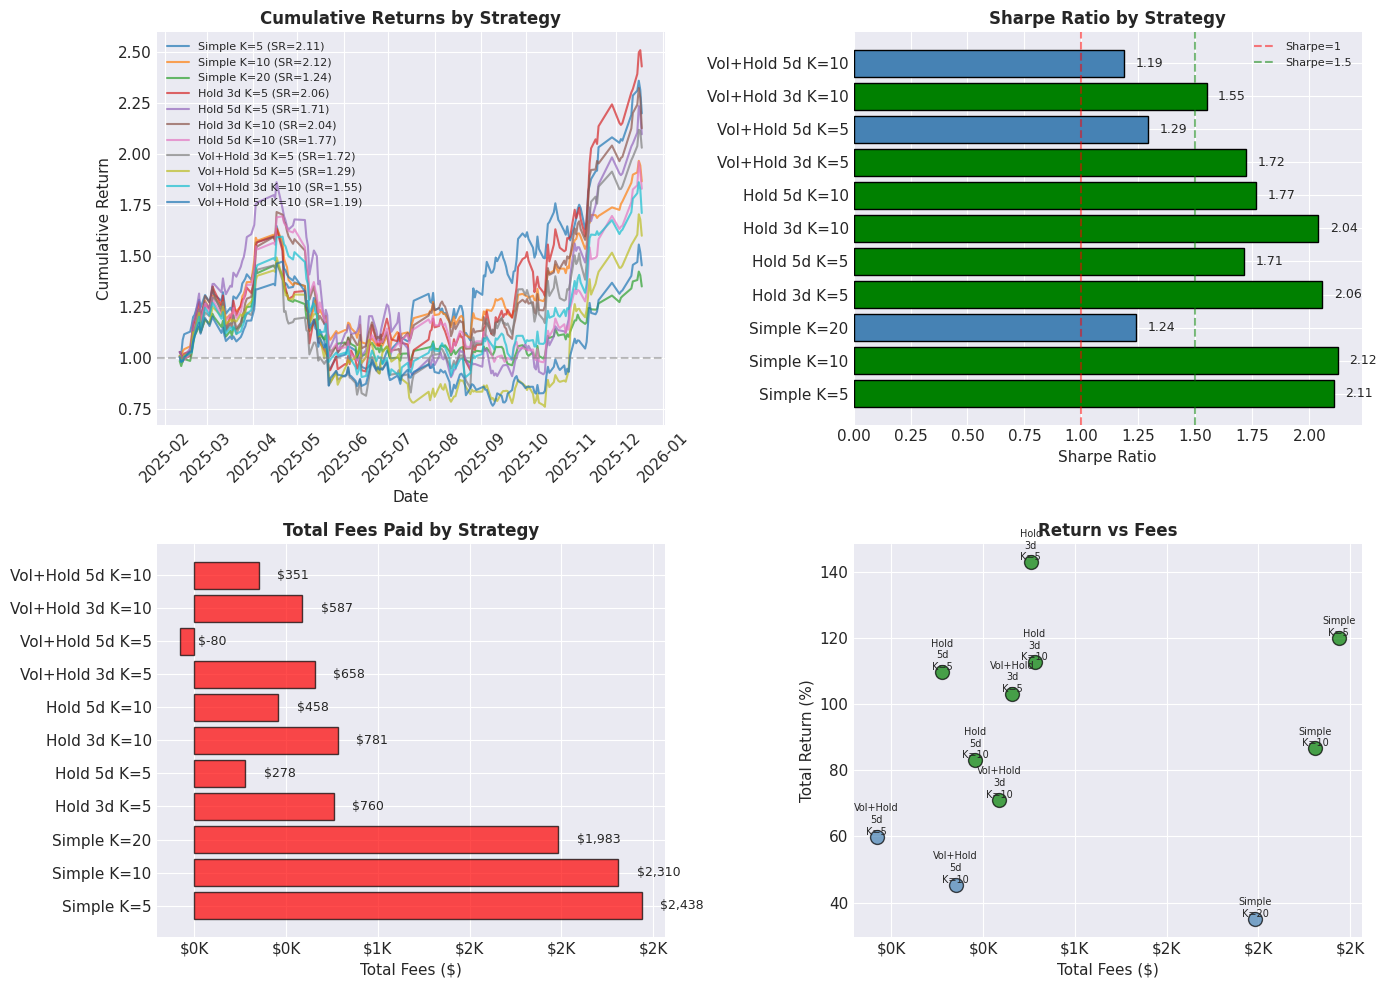


Saved plot to data/strategy_comparison.png


In [31]:
# Plot cumulative returns for all strategies
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative returns comparison
ax1 = axes[0, 0]
for name, strat in strategies.items():
    results = strat["results"]
    cum_ret = (1 + results["return"]).cumprod()
    ax1.plot(results["date"], cum_ret, label=f'{name} (SR={strat["metrics"]["sharpe"]:.2f})', alpha=0.7)
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.set_title("Cumulative Returns by Strategy", fontsize=12, fontweight='bold')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return")
ax1.legend(fontsize=8, loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Sharpe ratio comparison
ax2 = axes[0, 1]
names = list(strategies.keys())
sharpes = [strategies[n]["metrics"]["sharpe"] for n in names]
colors = ['green' if s > 1.5 else 'steelblue' if s > 1 else 'orange' for s in sharpes]
bars = ax2.barh(names, sharpes, color=colors, edgecolor='black')
ax2.axvline(x=1, color='red', linestyle='--', alpha=0.5, label='Sharpe=1')
ax2.axvline(x=1.5, color='green', linestyle='--', alpha=0.5, label='Sharpe=1.5')
ax2.set_title("Sharpe Ratio by Strategy", fontsize=12, fontweight='bold')
ax2.set_xlabel("Sharpe Ratio")
ax2.legend(fontsize=8)
# Add value labels
for bar, val in zip(bars, sharpes):
    ax2.text(val + 0.05, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center', fontsize=9)

# Plot 3: Total fees comparison
ax3 = axes[1, 0]
fees = [strategies[n]["metrics"]["total_fees"] for n in names]
ax3.barh(names, fees, color='red', alpha=0.7, edgecolor='black')
ax3.set_title("Total Fees Paid by Strategy", fontsize=12, fontweight='bold')
ax3.set_xlabel("Total Fees ($)")
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
# Add value labels
for i, (bar, val) in enumerate(zip(ax3.patches, fees)):
    ax3.text(val + 100, bar.get_y() + bar.get_height()/2, f'${val:,.0f}', va='center', fontsize=9)

# Plot 4: Return vs Fees scatter
ax4 = axes[1, 1]
returns = [strategies[n]["metrics"]["total_return"] for n in names]
for name, ret, fee, sharpe in zip(names, returns, fees, sharpes):
    color = 'green' if sharpe > 1.5 else 'steelblue' if sharpe > 1 else 'orange'
    ax4.scatter(fee, ret, s=100, c=color, edgecolor='black', alpha=0.7)
    ax4.annotate(name.replace(' ', '\n'), (fee, ret), fontsize=7, ha='center', va='bottom')
ax4.set_title("Return vs Fees", fontsize=12, fontweight='bold')
ax4.set_xlabel("Total Fees ($)")
ax4.set_ylabel("Total Return (%)")
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig("data/strategy_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved plot to data/strategy_comparison.png")

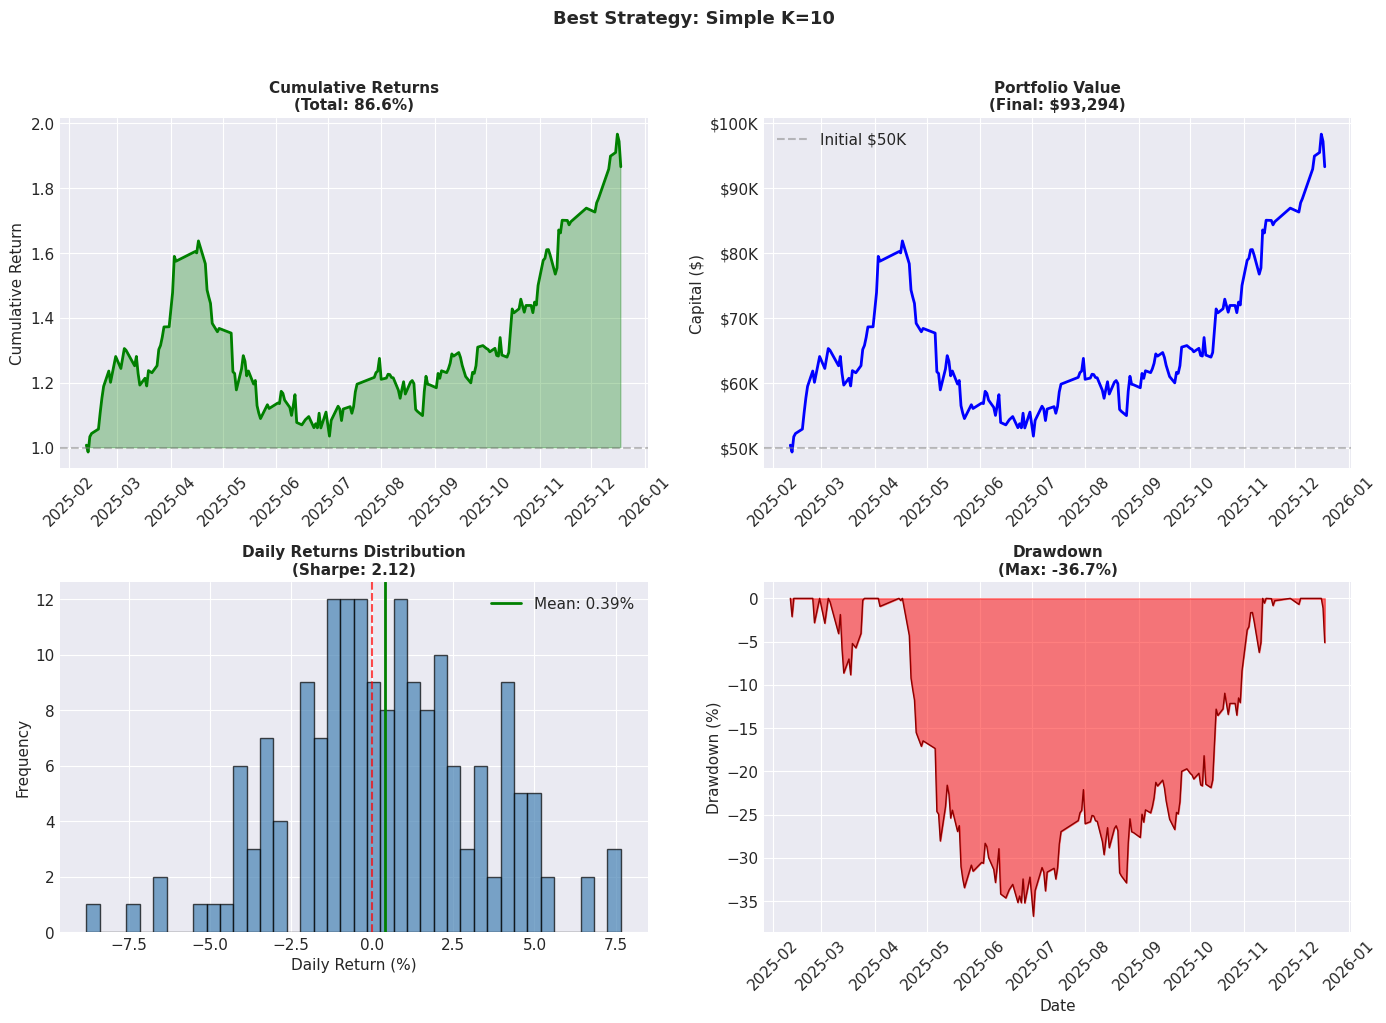

In [32]:
# Detailed plots for best strategy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

daily_returns = best_results["return"]

# Plot 1: Cumulative returns
ax1 = axes[0, 0]
cum_returns = (1 + daily_returns).cumprod()
ax1.plot(best_results["date"], cum_returns, linewidth=2, color='green')
ax1.fill_between(best_results["date"], 1, cum_returns, 
                  where=(cum_returns >= 1), alpha=0.3, color='green')
ax1.fill_between(best_results["date"], 1, cum_returns, 
                  where=(cum_returns < 1), alpha=0.3, color='red')
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.set_title(f"Cumulative Returns\n(Total: {best_metrics['total_return']:.1f}%)", fontsize=11, fontweight='bold')
ax1.set_ylabel("Cumulative Return")
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Capital over time
ax2 = axes[0, 1]
ax2.plot(best_results["date"], best_results["capital"], linewidth=2, color='blue')
ax2.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label=f'Initial ${INITIAL_CAPITAL//1000}K')
ax2.set_title(f"Portfolio Value\n(Final: ${best_results['capital'].iloc[-1]:,.0f})", fontsize=11, fontweight='bold')
ax2.set_ylabel("Capital ($)")
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# Plot 3: Daily returns distribution
ax3 = axes[1, 0]
ax3.hist(daily_returns * 100, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax3.axvline(x=daily_returns.mean() * 100, color='green', linestyle='-', linewidth=2, 
            label=f'Mean: {daily_returns.mean()*100:.2f}%')
ax3.set_title(f"Daily Returns Distribution\n(Sharpe: {best_metrics['sharpe']:.2f})", fontsize=11, fontweight='bold')
ax3.set_xlabel("Daily Return (%)")
ax3.set_ylabel("Frequency")
ax3.legend()

# Plot 4: Drawdown
ax4 = axes[1, 1]
rolling_max = cum_returns.expanding().max()
drawdown = (cum_returns - rolling_max) / rolling_max * 100
ax4.fill_between(best_results["date"], drawdown, 0, alpha=0.5, color='red')
ax4.plot(best_results["date"], drawdown, color='darkred', linewidth=1)
ax4.set_title(f"Drawdown\n(Max: {best_metrics['max_dd']:.1f}%)", fontsize=11, fontweight='bold')
ax4.set_xlabel("Date")
ax4.set_ylabel("Drawdown (%)")
ax4.tick_params(axis='x', rotation=45)

plt.suptitle(f"Best Strategy: {best_name}", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("data/best_strategy_results.png", dpi=150, bbox_inches='tight')
plt.show()

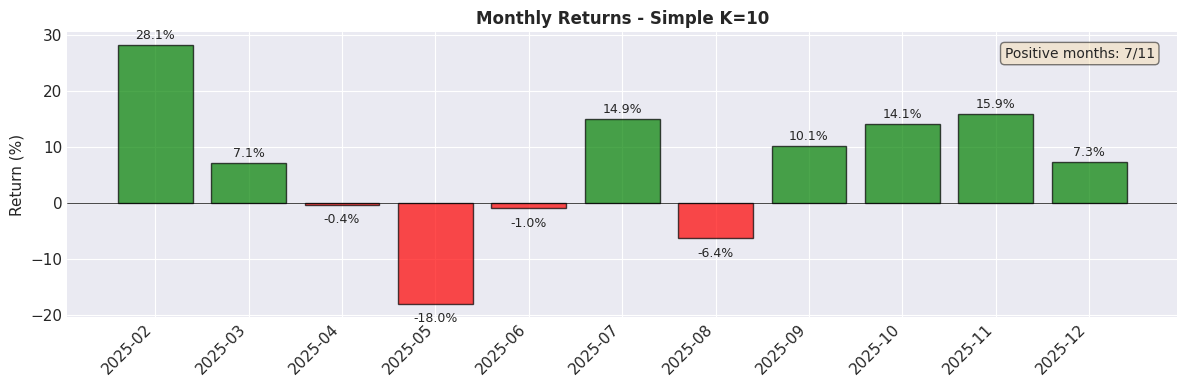

In [33]:
# Monthly returns bar chart
best_results["month"] = best_results["date"].dt.to_period("M")
monthly = best_results.groupby("month")["return"].apply(lambda x: (1 + x).prod() - 1)
monthly_df = monthly.reset_index()
monthly_df["return_pct"] = monthly_df["return"] * 100

fig, ax = plt.subplots(figsize=(12, 4))

monthly_returns = monthly_df["return_pct"].values
months = [str(m) for m in monthly_df["month"]]

colors = ['red' if r < 0 else 'green' for r in monthly_returns]
bars = ax.bar(range(len(months)), monthly_returns, color=colors, edgecolor='black', alpha=0.7)

ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xticks(range(len(months)))
ax.set_xticklabels(months, rotation=45, ha='right')
ax.set_ylabel("Return (%)")
ax.set_title(f"Monthly Returns - {best_name}", fontsize=12, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, monthly_returns)):
    ypos = bar.get_height() + (0.5 if val >= 0 else -1.5)
    ax.text(bar.get_x() + bar.get_width()/2, ypos, 
            f'{val:.1f}%', ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)

# Summary stats
positive_months = (monthly > 0).sum()
total_months = len(monthly)
ax.text(0.98, 0.95, f"Positive months: {positive_months}/{total_months}", 
        transform=ax.transAxes, ha='right', va='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

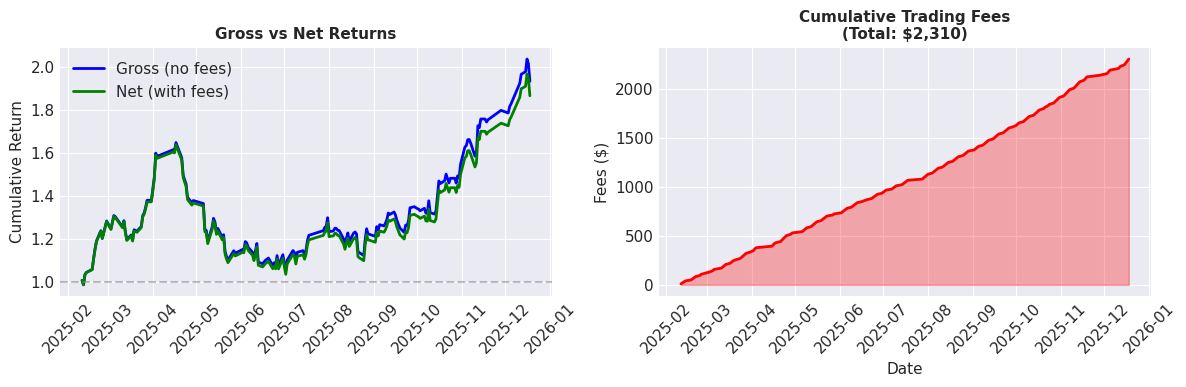


Fee Impact:
  Gross Return: 93.3%
  Net Return: 86.6%
  Fee Drag: 6.7%


In [34]:
# Fee impact analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compare gross vs net returns
ax1 = axes[0]
gross_cum = (1 + best_results["gross_pnl"] / best_results["capital"].shift(1).fillna(50_000)).cumprod()
net_cum = (1 + best_results["return"]).cumprod()

ax1.plot(best_results["date"], gross_cum, label="Gross (no fees)", linewidth=2, color='blue')
ax1.plot(best_results["date"], net_cum, label="Net (with fees)", linewidth=2, color='green')
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.set_title("Gross vs Net Returns", fontsize=11, fontweight='bold')
ax1.set_ylabel("Cumulative Return")
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Cumulative fees
ax2 = axes[1]
cum_fees = best_results["fees"].cumsum()
ax2.plot(best_results["date"], cum_fees, linewidth=2, color='red')
ax2.fill_between(best_results["date"], 0, cum_fees, alpha=0.3, color='red')
ax2.set_title(f"Cumulative Trading Fees\n(Total: ${best_metrics['total_fees']:,.0f})", fontsize=11, fontweight='bold')
ax2.set_xlabel("Date")
ax2.set_ylabel("Fees ($)")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print fee summary
gross_return = (gross_cum.iloc[-1] - 1) * 100
net_return = (net_cum.iloc[-1] - 1) * 100
fee_drag = gross_return - net_return
print(f"\nFee Impact:")
print(f"  Gross Return: {gross_return:.1f}%")
print(f"  Net Return: {net_return:.1f}%")
print(f"  Fee Drag: {fee_drag:.1f}%")

In [35]:
# Save results
best_results.drop(columns=["symbols", "month"]).to_parquet("data/short_backtest_improved.pqt", index=False)
comparison_df.to_csv("data/strategy_comparison.csv")

print("Saved:")
print("  - data/short_backtest_improved.pqt")
print("  - data/strategy_comparison.csv")
print("  - data/strategy_comparison.png")
print("  - data/best_strategy_results.png")

Saved:
  - data/short_backtest_improved.pqt
  - data/strategy_comparison.csv
  - data/strategy_comparison.png
  - data/best_strategy_results.png
